In [1]:
cd ..

/home/felixlau/devel/nolearn_utils


In [53]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from io import BytesIO
import base64
import PIL
import matplotlib.gridspec as gridspec
import lasagne as nn
import cPickle as pickle

from IPython.display import HTML

from nolearn_utils.iterators import make_iterator

from examples.cifar10.train import net, load_data, train_iterator_mixins, train_iterator_kwargs

def nparray_to_img_html(arr, size='auto'):
    b = BytesIO()
    width = 'auto' if size == 'auto' else '%ipx' % (arr.shape[0] * size)
    height = 'auto' if size == 'auto' else '%ipx' % (arr.shape[1] * size)
    arr = (arr.copy() * 255).astype(np.uint8)
    img = PIL.Image.fromarray(arr)
    img.save(b, format='png')
    html = """<img src="data:image/png;base64,{png}" style="width: {width}; height: {height}; display: inline-block;">""".format(
        png=base64.b64encode(b.getvalue()),
        width=width,
        height=height
    )
    return html

def get_layer_type(layer):
    name = layer.__class__.__name__.lower()
    if 'dense' in name:
        return 'fc'
    elif 'conv' in name:
        return 'conv'
    elif 'pool' in name:
        return 'pool'
    else:
        return 'unknown'
    
def render_conv_layer_weights(layer, size=10):
    params = layer.get_params()
    params = [(param.name, np.array(param.eval())) for param in params]
    name, filters = params[0]

    html = '<div class="conv-weight" id="{layer_id}">'.format(layer_id=name)
    for fs in filters:
        h = '<span>('
        for f in fs:
            h += nparray_to_img_html(f, size=size) + ' '
        h += ')</span>'
        html += h
    html += '</div>'
    return html

def render_conv_activation(layer, img, size=2):
    img = img.transpose(2, 0, 1)
    layer_input = img[np.newaxis, :, :, :]
    
    layer_output = np.array(nn.layers.get_output(layer, layer_input).eval())
    layer_output -= layer_output.mean()
    layer_output /= (layer_output.max() - layer_output.min())
    
    name = layer.name
    html = '<div class="conv-activation" id="{layer_id}">'.format(layer_id=name)
    for output in layer_output[0]:
        html += nparray_to_img_html(output, size=size)
    html += '</div>'

    return html

def render_pool_activation(layer, img, size=2):
    pass

def render_fc_activation(layer, img, size=2):
    pass

In [114]:
net.load_params_from('./examples/cifar10/model_weights.pkl')

Loaded parameters to layer 'l1c1' (shape 16x3x3x3).
Loaded parameters to layer 'l1c1' (shape 16).
Loaded parameters to layer 'l1c2' (shape 16x16x3x3).
Loaded parameters to layer 'l1c2' (shape 16).
Loaded parameters to layer 'l1c3' (shape 32x16x3x3).
Loaded parameters to layer 'l1c3' (shape 32).
Loaded parameters to layer 'l2c1' (shape 32x32x3x3).
Loaded parameters to layer 'l2c1' (shape 32).
Loaded parameters to layer 'l2c2' (shape 32x32x3x3).
Loaded parameters to layer 'l2c2' (shape 32).
Loaded parameters to layer 'l2c3' (shape 64x32x3x3).
Loaded parameters to layer 'l2c3' (shape 64).
Loaded parameters to layer 'l7' (shape 3136x512).
Loaded parameters to layer 'l7' (shape 512).
Loaded parameters to layer 'l8' (shape 256x512).
Loaded parameters to layer 'l8' (shape 512).
Loaded parameters to layer 'out' (shape 256x10).
Loaded parameters to layer 'out' (shape 10).


In [66]:
X_train, X_test, y_train, y_test = load_data(test_size=0.25, random_state=42, data_dir='./examples/cifar10/data')
# prefix = '/home/felixlau/devel/nolearn_utils/examples/cifar10/data/train'
# X_train = np.asarray(map(lambda path: os.path.join(prefix, path), X_train))

In [71]:
TrainIterator = make_iterator('TrainIterator', train_iterator_mixins[:-1])
if 'buffer_size' in train_iterator_kwargs:
    del train_iterator_kwargs['buffer_size']
train_iterator_kwargs['read_image_prefix_path'] = './examples/cifar10/data/train/'
train_iterator = TrainIterator(**train_iterator_kwargs)

In [83]:
Xb, yb = iter(train_iterator(X_train, y_train)).next()

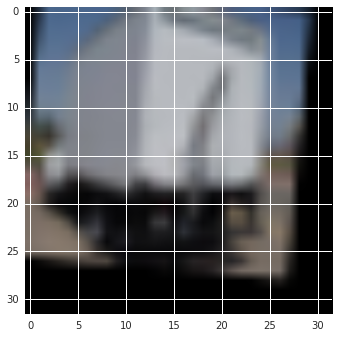

In [115]:
# i = 10
img = Xb[10].transpose(1, 2, 0)
plt.imshow(img)

## Layer visualization

http://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html

- Output each image as html

In [116]:
layers = net.get_all_layers()

layer = layers[1]
layer_type = get_layer_type(layer)

print layer_type

conv



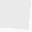
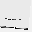
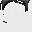
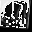
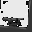
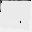
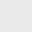
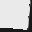
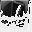
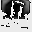
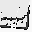
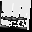
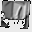
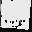
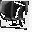
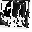

In [118]:
HTML(render_conv_activation(layer, img, size=2))

In [120]:
HTML(render_conv_layer_weights(layer, size=5))

## Validation / Training Loss over time

14.1061306696


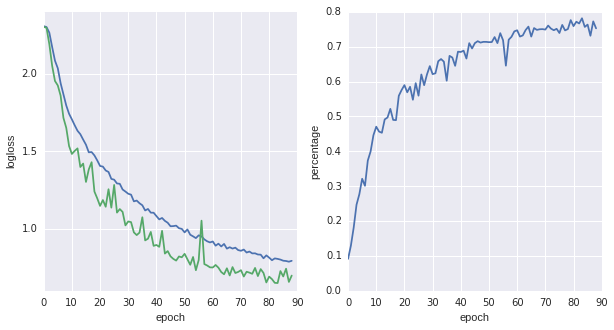

In [125]:
with open('./examples/cifar10/model_history.pkl', 'r') as f:
    training_history = pickle.load(f)
train_losses = [h['train_loss'] for h in training_history]
valid_losses = [h['valid_loss'] for h in training_history]
valid_acc = [h['valid_accuracy'] for h in training_history]
duration = [h['dur'] for h in training_history]

print np.mean(duration)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.plot(valid_losses)
plt.ylabel('logloss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(valid_acc)
plt.ylabel('percentage')
plt.xlabel('epoch')